In [1]:
import cv2 # computer vision library
import helpers # helper functions

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # for loading in images

%matplotlib inline


# Image data directories
IMAGE_DIR_TRAINING = "traffic_light_images/training/"
IMAGE_DIR_TEST = "traffic_light_images/test/"


# Using the load_dataset function in helpers.py
# Load training data
IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TRAINING)


# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):
    
    standard_im = np.copy(image)
    standard_im = cv2.resize(standard_im, (32,32))
    
    return standard_im


def one_hot_encode(label):
    
    one_hot_encoded = [] 
    if label == "red":
        one_hot_encoded = [1,0,0]
    elif label == "yellow":
        one_hot_encoded = [0,1,0]
    elif label == "green":
        one_hot_encoded = [0,0,1]
    return one_hot_encoded


def standardize(image_list):
    
    # Empty image data array
    standard_list = []

    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]

        # Standardize the image
        standardized_im = standardize_input(image)

        # One-hot encode the label
        one_hot_label = one_hot_encode(label)    

        # Append the image, and it's one hot encoded label to the full, processed list of image data 
        standard_list.append((standardized_im, one_hot_label))
        
    return standard_list

# Standardize all training images
STANDARDIZED_LIST = standardize(IMAGE_LIST)

# 版本2
## 效果
- Accuracy: 0.9461279461279462
- Number of misclassified images = 16 out of 297
- 有红灯被判断为绿灯
```
for i in range(len(MISCLASSIFIED)):
    print(MISCLASSIFIED[i][1], MISCLASSIFIED[i][2])
# predicted_label, true_label
[1, 0, 0] [0, 0, 1]
[1, 0, 0] [0, 0, 1]
[1, 0, 0] [0, 0, 1]
[1, 0, 0] [0, 0, 1]
[0, 0, 1] [1, 0, 0]
[0, 0, 1] [1, 0, 0]
[0, 0, 1] [1, 0, 0]
[1, 0, 0] [0, 0, 1]
[1, 0, 0] [0, 0, 1]
[1, 0, 0] [0, 0, 1]
[1, 0, 0] [0, 0, 1]
[1, 0, 0] [0, 1, 0]
[0, 1, 0] [1, 0, 0]
[1, 0, 0] [0, 0, 1]
[0, 1, 0] [1, 0, 0]
[0, 1, 0] [1, 0, 0]
```

## 方法:
- 采用v平均值创建v_mask,采用s平均值创建s_mask
- 合并成一个mask
- cv2.findContours找到mask(反二值化)中的最大的图形轮廓所在的位置
- 通过位置判断红路灯(绿灯再加上rgb颜色判断, g>r)
 
## 问题:
- 有些图片中的红绿灯整体位置偏移(偏上或者偏下), 导致找到的位置偏上或偏下
- 部分mask包括了边缘的大块背景图像,

## 解决方案:
- 裁剪: 
  - cv2.findContours找v或者s的mask中的主体,裁剪出红路灯主体所在的图片
  - 得到灯轮廓在裁剪后图片的相对位置
- 改变mask合并方式
  - v_mask反转cv2.bitwise_not之后与s_mask进行与操作cv2.bitwise_and

In [94]:
def cut(v_mask,mask,rgb_image):
    # 获取图像轮廓坐标，其中contours为坐标值，此处只检测外形轮廓
    image, contours, hierarchy = cv2.findContours(v_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 找最大块位置
    mx = 0
    my = 0
    mw = 0
    mh = 0
    if len(contours) > 0:
        #cv2.boundingRect()返回轮廓矩阵的坐标值，四个值为x, y, w, h， 其中x, y为左上角坐标，w,h为矩阵的宽和高
        boxes = [cv2.boundingRect(c) for c in contours]
        for box in boxes:
            x, y, w, h = box

            if w * h > mw * mh:
                mw = w
                mh = h
                mx = x
                my = y
    
    
    # 最大块中心
    center_x = mx + mw/2
    center_y = my + mh/2
    
    cuted_mask = mask[my:(my+mh), mx:(mx+mw)]
    cuted_image = rgb_image[my:(my+mh), mx:(mx+mw), :]
    
    return [cuted_mask, cuted_image]

In [217]:
def create_hsv_mask1(rgb_image):
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    
    sum_brightness = np.sum(hsv_image[:,:,2])
    area = 32*32
    avg_v = int(sum_brightness/area)
    # 创建蒙版, 明度
    v_lower = np.array([0,0,0])
    v_upper = np.array([179,255,avg_v])
    v_mask = cv2.inRange(hsv_image, v_lower, v_upper)


    sum_s = np.sum(hsv_image[:,:,1])
    area = 32*32
    avg_s = int(sum_s/area)
    # 创建蒙版, 饱和度
    s_lower = np.array([0,0,0])
    s_upper = np.array([179,avg_s,255])
    s_mask = cv2.inRange(hsv_image, s_lower, s_upper)
    # 膨胀操作
#     kernel = np.ones((2, 2), np.uint8)
#     s_mask = cv2.dilate(s_mask, kernel, iterations=1)
    
    
    
    # 创建蒙版, h
    red_lower = np.array([170,43,46])  # 可以选中红, 适当缩小范围
    red_upper = np.array([177,255,255])  # 可以选中红, 适当缩小范围
    yellow_lower = np.array([10,43,46])  # 适当放大黄色范围
    yellow_upper = np.array([35,255,255])
    green_lower = np.array([35,43,46])  
    green_upper = np.array([100,255,255])  # 绿色有些图片中偏向青色和蓝色,放宽h值范围
    mask_red = cv2.inRange(hsv_image, red_lower, red_upper)
    mask_yg = cv2.inRange(hsv_image, yellow_lower, green_upper)  # 黄色和绿色的蒙版可以合并
    h_mask = cv2.bitwise_or(mask_red, mask_yg)
    # 膨胀操作
    kernel = np.ones((2, 2), np.uint8)
    h_mask = cv2.dilate(h_mask, kernel, iterations=1)
    
    
    
    
    # 合并蒙版
    mask = cv2.bitwise_or(v_mask, s_mask)
    
    # 遮盖图像 rgb
    masked_image = np.copy(rgb_image)
    masked_image[mask != 0] = [0, 0, 0]
    
    # 按照v_mask切割出路灯主体
    cuted_mask = cut(v_mask, mask, rgb_image)[0]
    cuted_image = cut(v_mask, mask, rgb_image)[1]
    # 先膨胀操作, 后腐蚀操作
    kernel = np.ones((2, 2), np.uint8)
    cuted_mask = cv2.dilate(cuted_mask, kernel, iterations=1)
    cuted_mask = cv2.erode(cuted_mask, kernel, iterations=1)
    # 遮盖图像 rgb
    masked_cuted_image = np.copy(cuted_image)
    masked_cuted_image[cuted_mask != 0] = [0, 0, 0]    
    

    f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20,8))
    ax0.imshow(test_im)
    ax0.set_title("image")

    ax1.imshow(s_mask, cmap='gray')
    ax1.set_title("s_mask")

    ax2.imshow(v_mask, cmap='gray')
    ax2.set_title("v_mask")

    ax3.imshow(mask, cmap='gray')
    ax3.set_title("mask")

    ax4.imshow(masked_image)
    ax4.set_title("masked_image")

    plt.show()
    
    f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20,8))
    ax0.imshow(test_im)
    ax0.set_title("image")

    ax1.imshow(s_mask, cmap='gray')
    ax1.set_title("s_mask")

    ax2.imshow(cuted_image)
    ax2.set_title("cuted_image")

    ax3.imshow(cuted_mask, cmap='gray')
    ax3.set_title("cuted_mask")

    ax4.imshow(masked_cuted_image)
    ax4.set_title("masked_cuted_image")

    plt.show()
    return cuted_mask, masked_cuted_image

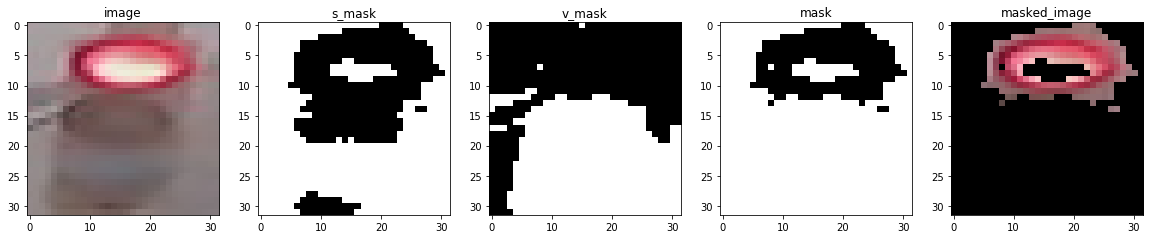

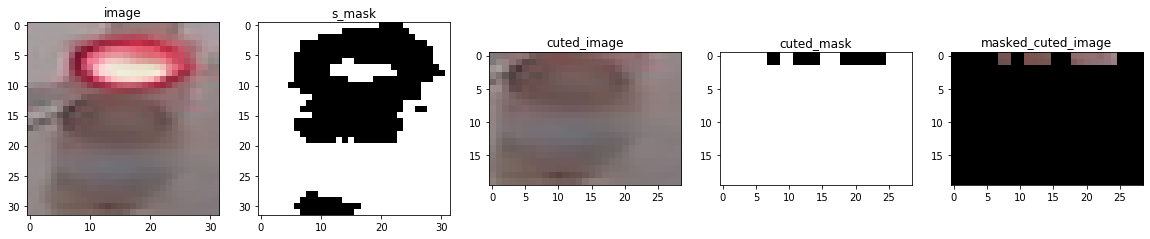

[1, 0, 0]


In [225]:
image_num = 1
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]
create_hsv_mask1(test_im)
print(test_label)

In [160]:
def create_feature1(rgb_image):
    """
    寻找轮廓:https://blog.csdn.net/chenghaoy/article/details/86509950
    """
    
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    cuted_mask, masked_cuted_image = create_hsv_mask1(rgb_image)
    
    # mask反二值化
    # ret,thresh2 = cv2.threshold(test_im,127,255,cv2.THRESH_BINARY_INV)
    cuted_mask_inv = cv2.bitwise_not(cuted_mask)
    # 获取图像轮廓坐标，其中contours为坐标值，此处只检测外形轮廓
    image, contours, hierarchy = cv2.findContours(cuted_mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 找最大块位置
    mx = 0
    my = 0
    mw = 0
    mh = 0
    if len(contours) > 0:
        #cv2.boundingRect()返回轮廓矩阵的坐标值，四个值为x, y, w, h， 其中x, y为左上角坐标，w,h为矩阵的宽和高
        boxes = [cv2.boundingRect(c) for c in contours]
        masked_cuted_image2 = masked_cuted_image.copy()
        for box in boxes:
            x, y, w, h = box
#             print("轮廓矩阵坐标值",x,y,w,h)

            #绘制矩形框对轮廓进行定位
            masked_cuted_image2 = cv2.rectangle(masked_cuted_image2, (x, y), (x+w, y+h), (153, 153, 0), 1)
            
            if w * h > mw * mh:
                mw = w
                mh = h
                mx = x
                my = y
                
    # cuted_mask_inv 最大块中心 相对位置
    width = np.shape(cuted_mask)[0]
    height = np.shape(cuted_mask)[1]
    center_x = (mx + mw/2) / width
    center_y = my + mh/2 / height
    
#     plt.imshow(masked_image2)
#     plt.show()
    
    
    # 未被遮盖的像素总数
    sum_pix = 32*32 - np.sum(cuted_mask)/255
    if sum_pix == 0:
        return [0,0,0,0]
    
    # 未被遮盖的像素的平均h,s,v
    sum_h = np.sum(masked_cuted_image[:,:,0])
    avg_h = sum_h/sum_pix
    sum_s = np.sum(masked_cuted_image[:,:,1])
    avg_s = sum_s/sum_pix
    sum_v = np.sum(masked_cuted_image[:,:,2])
    avg_v = sum_v/sum_pix
#     print("hsv_feature:", sum_h, sum_s, sum_v, sum_pix)
    
    
    # RGB 图像
    r = rgb_image[:,:,0]
    g = rgb_image[:,:,1]
    b = rgb_image[:,:,2]
    avg_r = r.sum()/(32*32)
    avg_g = g.sum()/(32*32)
    avg_b = b.sum()/(32*32)
#     r = masked_image[:,:,0]
#     g = masked_image[:,:,1]
#     b = masked_image[:,:,2]
#     avg_r = r.sum()/sum_pix
#     avg_g = g.sum()/sum_pix
#     avg_b = b.sum()/sum_pix
    
#     f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,8))
#     ax0.imshow(r, cmap='gray')
#     ax0.set_title("r:{}".format(avg_r))
#     ax1.imshow(g, cmap='gray')
#     ax1.set_title("g:{}".format(avg_g))
#     ax2.imshow(b, cmap='gray')
#     ax2.set_title("b:{}".format(avg_b))
#     plt.show()
    
    
    feature = [center_y, avg_r, avg_g, avg_h, avg_s, avg_v]
    return feature

In [161]:
image_num = 1

test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]
print(create_feature1(test_im))
print(test_label,estimate_label(test_im))

[0.0625, 144.595703125, 115.017578125, 18.92622950819672, 10.816939890710383, 11.816939890710383]
[1, 0, 0] [1, 0, 0]


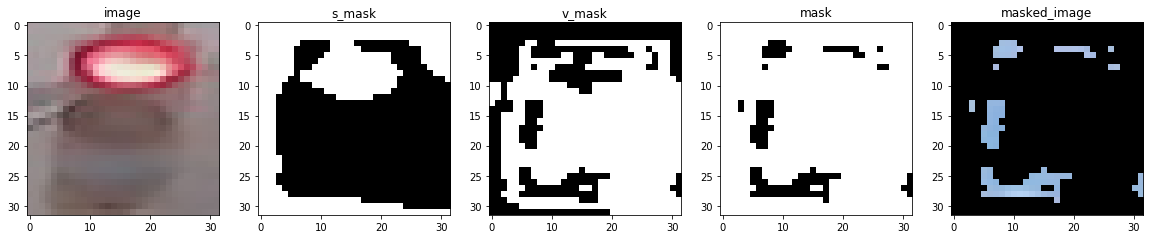

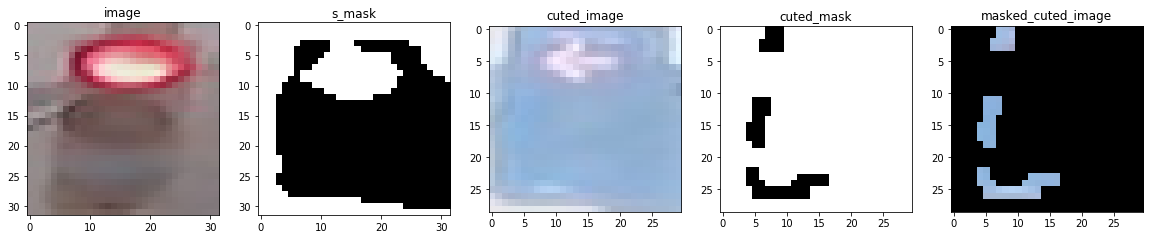

[22.083333333333332, 170.501953125, 190.7294921875, 48.836283185840706, 58.57079646017699, 70.51769911504425]


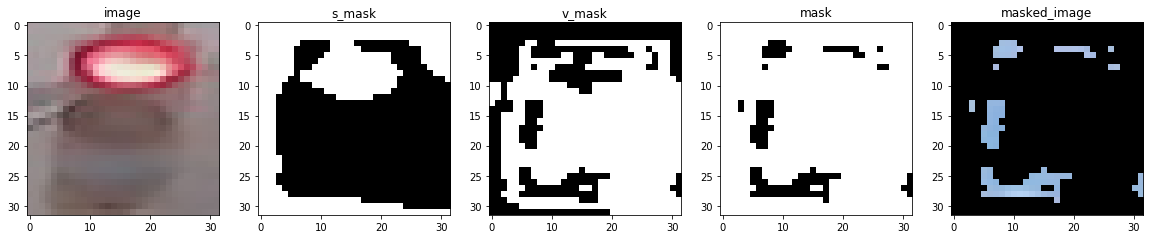

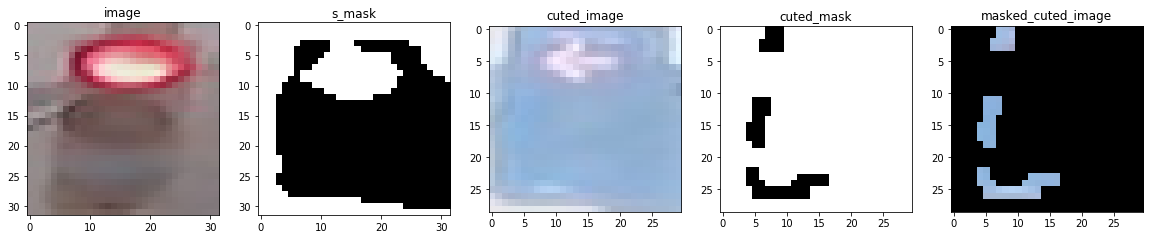

[0, 0, 1]


In [177]:

print(create_feature1(im))
print(estimate_label(im))

（实现）：构建一个完整的分类器

In [169]:
# This function should take in RGB image input
# Analyze that image using your feature creation code and output a one-hot encoded label
def estimate_label(rgb_image):
    
    ## TODO: Extract feature(s) from the RGB image and use those features to
    ## classify the image and output a one-hot encoded label
    predicted_label = [1,0,0]
    
    feature = create_feature1(rgb_image)
#     print(feature)

    y = feature[0]
    r = feature[1]
    g = feature[2]
    h = feature[3]
    if y <= 0.4 or h > 160:
        predicted_label = [1,0,0]
    elif y < 0.6 and y > 0.4 or h < 20:
        predicted_label = [0,1,0]
    elif y >= 0.6 and g > r:
        predicted_label = [0,0,1]
    
    return predicted_label   
    

In [170]:
# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TEST)

# Standardize the test data
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

In [171]:
# Constructs a list of misclassified images given a list of test images and their labels
# This will throw an AssertionError if labels are not standardized (one-hot encoded)

def get_misclassified_images(test_images):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]
        assert(len(true_label) == 3), "The true_label is not the expected length (3)."

        # Get predicted label from your classifier
        predicted_label = estimate_label(im)
        assert(len(predicted_label) == 3), "The predicted_label is not the expected length (3)."

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels


# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))


Accuracy: 0.8114478114478114
Number of misclassified images = 56 out of 297


In [172]:
for i in range(len(MISCLASSIFIED)):
    print(MISCLASSIFIED[i][1], MISCLASSIFIED[i][2])

[1, 0, 0] [0, 0, 1]
[0, 0, 1] [1, 0, 0]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[1, 0, 0] [0, 1, 0]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [1, 0, 0]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[1, 0, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 0, 1] [1, 0, 0]
[1, 0, 0] [0, 1, 0]
[1, 0, 0] [0, 1, 0]
[1, 0, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[1, 0, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [1, 0, 0]
[0, 1, 0] [0, 0, 1]
[1, 0, 0] [0, 1, 0]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[1, 0, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[1, 0, 0] [0, 0, 1]
[1, 0, 0] [0, 0, 1]
[1, 0, 0] [0, 1, 0]
[0, 1, 0] [1, 0, 0]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[1, 0, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[0, 1, 0] [0, 0, 1]
[1, 0, 0] [0, 1, 0]
[1, 0, 0] [0, 1, 0]
[1, 0, 0] [0, 1, 0]
[0, 1, 0] [0, 0, 1]


[0, 0, 1] [1, 0, 0]


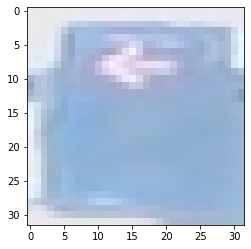

In [173]:
# Visualize misclassified example(s)
## TODO: Display an image in the `MISCLASSIFIED` list 
## TODO: Print out its predicted label - to see what the image *was* incorrectly classified as

image_num = 1

im = MISCLASSIFIED[image_num][0]
predicted_label = MISCLASSIFIED[image_num][1]
true_label = MISCLASSIFIED[image_num][2]
print(predicted_label, true_label)
plt.imshow(im)


In [174]:
# Importing the tests
import test_functions
tests = test_functions.Tests()

if(len(MISCLASSIFIED) > 0):
    # Test code for one_hot_encode function
    tests.test_red_as_green(MISCLASSIFIED)
else:
    print("MISCLASSIFIED may not have been populated with images.")


**<span style="color: red;">TEST FAILED</span>**


[0, 0, 1] == [0, 0, 1]


[0, 0, 1]


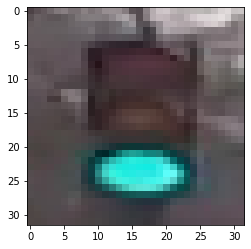

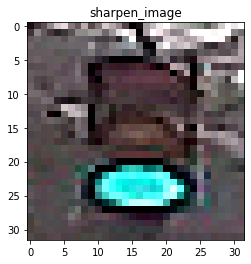

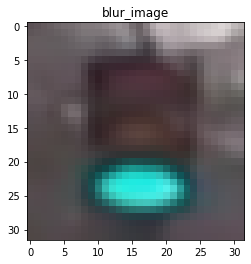

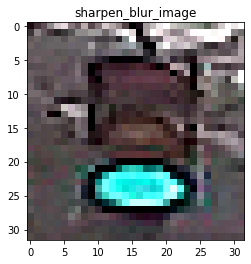

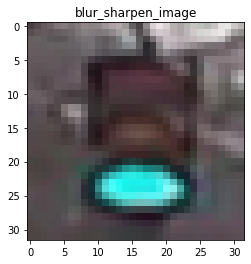

In [221]:
image_num = 1111
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]
print(test_label)

# Convert to grayscale for filtering

plt.imshow(test_im)
plt.show()


sharpen = np.array([[ 0, -1, 0], 
                   [ -1, 5, -1], 
                   [ 0, -1, 0]])
sharpen_image = cv2.filter2D(test_im, -1, sharpen)
plt.imshow(sharpen_image)
plt.title("sharpen_image")
plt.show()


blur = np.array([[ 0.0625, 0.125, 0.0625], 
                   [ 0.125, 0.25, 0.125], 
                   [ 0.0625, 0.125, 0.0625]])

blur_image = cv2.filter2D(test_im, -1, blur)
plt.imshow(blur_image)
plt.title("blur_image")
plt.show()




sharpen_blur_image = cv2.filter2D(blur_image, -1, sharpen)
plt.imshow(sharpen_image)
plt.title("sharpen_blur_image")
plt.show()


blur_sharpen_image = cv2.filter2D(sharpen_image, -1, blur)
plt.imshow(blur_sharpen_image)
plt.title("blur_sharpen_image")
plt.show()

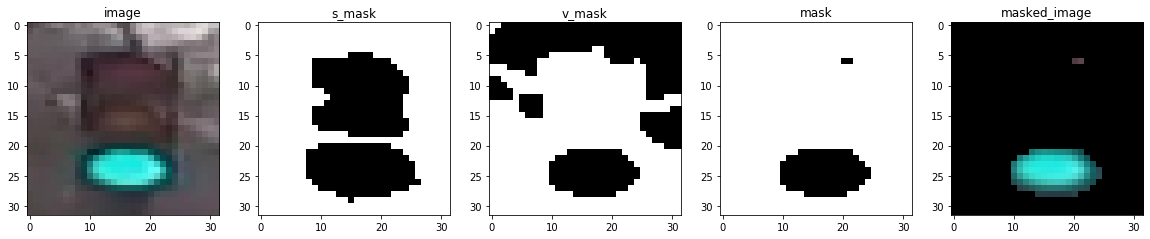

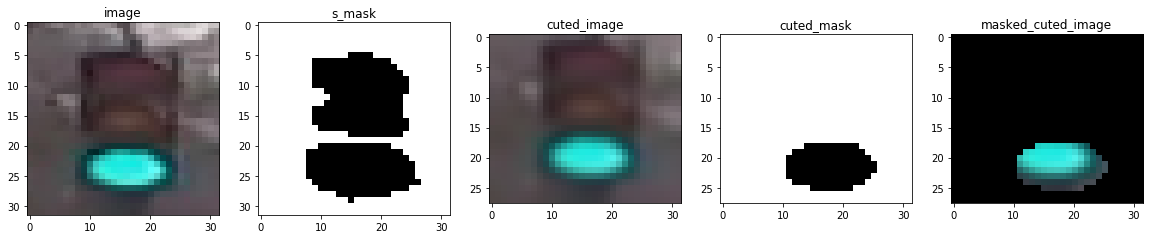

(array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2

In [222]:
create_hsv_mask1(blur_image)

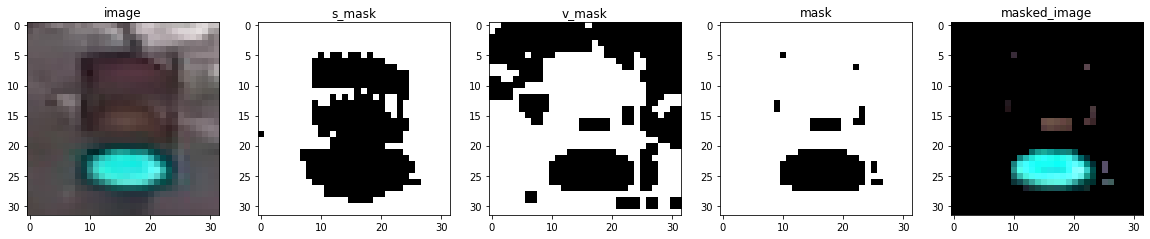

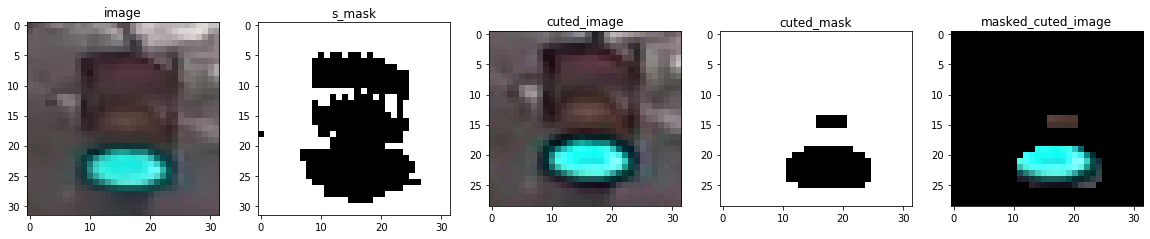

(array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2

In [223]:
create_hsv_mask1(sharpen_blur_image)

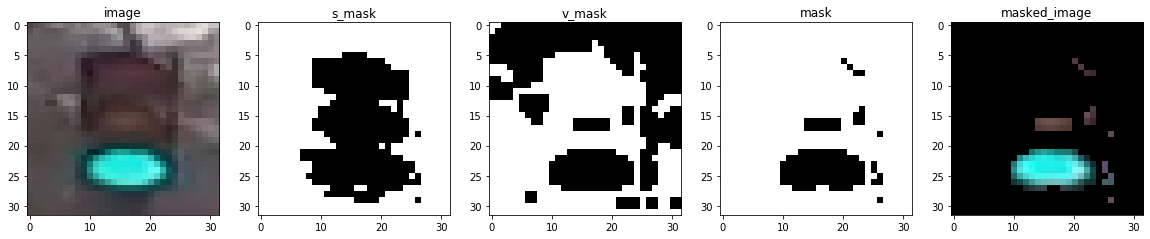

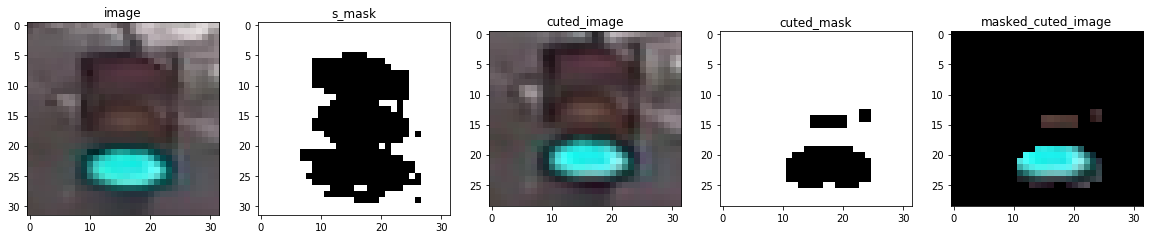

(array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
         255, 255, 255, 255, 255, 255],
        [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 2

In [224]:
create_hsv_mask1(blur_sharpen_image)